In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: <object object at 0x000001F9A3223820>


C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Lab 7
### Ian Eykamp

For the pre-lab, please see the separate notebook entitled `Lab7_calculations.ipynb` for snubber and clamp values and explanations.

## Oscilloscope Data

In [3]:
# 10 & 11: base values, HF & LF, Vdmax = 74.4V, Iin = 1.38A & 1.38A (?), Vout = 9.89V & 9.95V
# 12 & 13: HF resistor (10 ohm), HF & LF, Iin = 1.39A & 1.39A,Vdmax = 67.0V, Vout =  9.98V & 9.97V
# 14 & 15: LF resistor (100 ohm), LF & HF, Iin = 1.33A & 1.38A, Vdmax = 72.1, Vout = 9.75V & 9.93V
# Vin = 18V

# 49: failed, 1.39A, 9.93V Vd = 54.4
# 50: for funsies, 6.5V, 0.62A
# 51: FINAL, 9.93Vout, 1.39A Iin,  Vd = 54V

(df_baseline_hf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile10.csv", ch1 = "Vsh_baseline_hf", ch2 = "Vd_baseline_hf")
(df_baseline_lf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile11.csv", ch1 = "Vsh_baseline_lf", ch2 = "Vd_baseline_lf", shift = -79.5e-6)
(df_hf_snub_hf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile12.csv", ch1 = "Vsh_hf_snub_hf", ch2 = "Vd_hf_snub_hf")
(df_hf_snub_lf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile13.csv", ch1 = "Vsh_hf_snub_lf", ch2 = "Vd_hf_snub_lf", shift = 0.2e-6)
(df_lf_snub_hf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile15.csv", ch1 = "Vsh_lf_snub_hf", ch2 = "Vd_lf_snub_hf")
(df_lf_snub_lf, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile14.csv", ch1 = "Vsh_lf_snub_lf", ch2 = "Vd_lf_snub_lf")
(df_clamp, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/NewFile51.csv", ch1 = "Vsh", ch2 = "Vd", ch3 = "Vdiode", shift = 130e-9)

# Combine all variables into one for convenience
# df = df_4V_zoom1.set_index("t").join([df_4V.set_index("t"), df_7V.set_index("t"), df_9V.set_index("t"), df_9V_zoom1.set_index("t"), df_9V_zoom2.set_index("t")]).reset_index()
df_hf = df_baseline_hf.set_index("t").join([df_hf_snub_hf.set_index("t"), df_lf_snub_hf.set_index("t")]).reset_index()
df_lf = df_baseline_lf.set_index("t").join([df_hf_snub_lf.set_index("t"), df_lf_snub_lf.set_index("t")]).reset_index()
# df_clamp

Switching Losses
Baseline 123.82 µW
High Frequency Snubber 1.09 mW
Low Frequency Snubber 186.08 µW
High-Frequency Ringing
Baseline 1.44 mW
High Frequency Snubber 2.84 mW
Low Frequency Snubber 3.03 mW
High-Frequency Ringing AC Resistance
Baseline 134.74 mW
High Frequency Snubber 264.95 mW
Low Frequency Snubber 283.18 mW


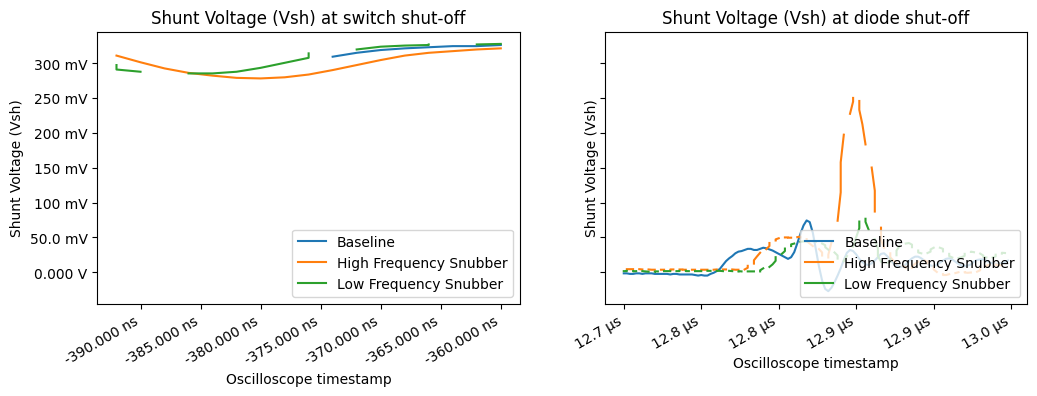

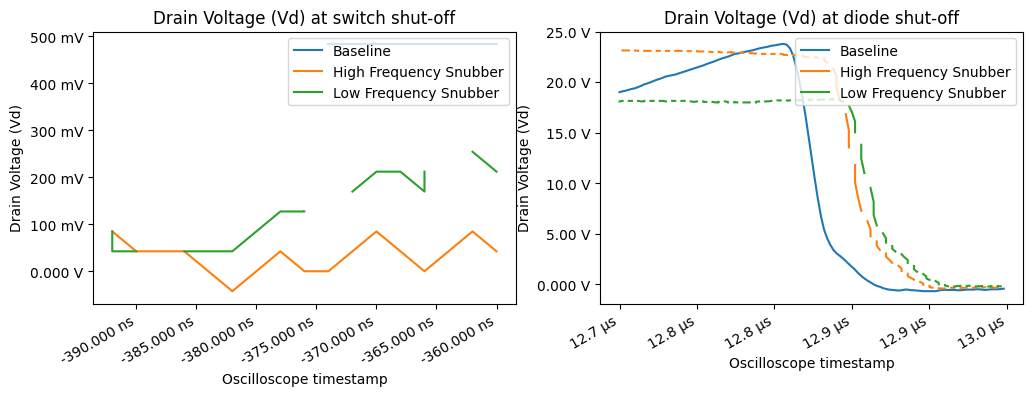

In [17]:
# Vshunt
df_hf_zoom = df_hf
# df_hf_zoom = df_hf[(df_hf["t"] > 0e-6) & (df_hf["t"] < 2e-6)]
df_lf_zoom = df_lf[(df_lf["t"] > 8e-6) & (df_lf["t"] < 13.5e-6)]
# df_lf_zoom = df_lf[(df_lf["t"] > 12.75e-6) & (df_lf["t"] < 13e-6)]

print("Switching Losses")
Vsh_baseline_lf_switch_area = np.trapz(df_lf_zoom[np.logical_not(np.isnan(df_lf_zoom["Vsh_baseline_lf"]))]["Vsh_baseline_lf"] ** 2, df_lf_zoom[np.logical_not(np.isnan(df_lf_zoom["Vsh_baseline_lf"]))]["t"])
print("Baseline", (Vsh_baseline_lf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
Vsh_hf_snub_lf_switch_area = np.trapz(df_lf_zoom[np.logical_not(np.isnan(df_lf_zoom["Vsh_hf_snub_lf"]))]["Vsh_hf_snub_lf"] ** 2, df_lf_zoom[np.logical_not(np.isnan(df_lf_zoom["Vsh_hf_snub_lf"]))]["t"])
print("High Frequency Snubber", (Vsh_hf_snub_lf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
Vsh_lf_snub_lf_switch_area = np.trapz(df_lf_zoom[np.logical_not(np.isnan(df_lf_zoom["Vsh_lf_snub_lf"]))]["Vsh_lf_snub_lf"] ** 2, df_lf_zoom[np.logical_not(np.isnan(df_lf_zoom["Vsh_lf_snub_lf"]))]["t"])
print("Low Frequency Snubber", (Vsh_lf_snub_lf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))

print("High-Frequency Ringing")
Vsh_baseline_hf_switch_area = np.trapz(df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_baseline_hf"]))]["Vsh_baseline_hf"] ** 2, df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_baseline_hf"]))]["t"])
print("Baseline", (Vsh_baseline_hf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
Vsh_hf_snub_hf_switch_area = np.trapz(df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_hf_snub_hf"]))]["Vsh_hf_snub_hf"] ** 2, df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_hf_snub_hf"]))]["t"])
print("High Frequency Snubber", (Vsh_hf_snub_hf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
Vsh_lf_snub_hf_switch_area = np.trapz(df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_lf_snub_hf"]))]["Vsh_lf_snub_hf"] ** 2, df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_lf_snub_hf"]))]["t"])
print("Low Frequency Snubber", (Vsh_lf_snub_hf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))

print("High-Frequency Ringing AC Resistance")
Vsh_baseline_hf_switch_area = np.trapz(df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_baseline_hf"]))]["Vsh_baseline_hf"] ** 2, df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_baseline_hf"]))]["t"])
print("Baseline", (Vsh_baseline_hf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * (4.67 * units.ohm / (0.05 * units.ohm)) * 50 * units.kilohertz).to_compact(units.watt))
Vsh_hf_snub_hf_switch_area = np.trapz(df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_hf_snub_hf"]))]["Vsh_hf_snub_hf"] ** 2, df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_hf_snub_hf"]))]["t"])
print("High Frequency Snubber", (Vsh_hf_snub_hf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * (4.67 * units.ohm / (0.05 * units.ohm)) * 50 * units.kilohertz).to_compact(units.watt))
Vsh_lf_snub_hf_switch_area = np.trapz(df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_lf_snub_hf"]))]["Vsh_lf_snub_hf"] ** 2, df_hf_zoom[np.logical_not(np.isnan(df_hf_zoom["Vsh_lf_snub_hf"]))]["t"])
print("Low Frequency Snubber", (Vsh_lf_snub_hf_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * (4.67 * units.ohm / (0.05 * units.ohm)) * 50 * units.kilohertz).to_compact(units.watt))

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) at switch shut-off", ax = ax1)
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vsh_baseline_hf"], label = "Baseline")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vsh_hf_snub_hf"], label = "High Frequency Snubber")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vsh_lf_snub_hf"], label = "Low Frequency Snubber")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) at diode shut-off", ax = ax2)
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vsh_baseline_lf"], label = "Baseline")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vsh_hf_snub_lf"], label = "High Frequency Snubber")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vsh_lf_snub_lf"], label = "Low Frequency Snubber")
ax2.legend(loc = "lower right")

# Vd
df_hf_zoom = df_hf
df_lf_zoom = df_lf[(df_lf["t"] > 8e-6) & (df_lf["t"] < 13.5e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) at switch shut-off", ax = ax1)
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vd_baseline_hf"], label = "Baseline")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vd_hf_snub_hf"], label = "High Frequency Snubber")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vd_lf_snub_hf"], label = "Low Frequency Snubber")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) at diode shut-off", ax = ax2)
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vd_baseline_lf"], label = "Baseline")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vd_hf_snub_lf"], label = "High Frequency Snubber")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vd_lf_snub_lf"], label = "Low Frequency Snubber")
ax2.legend(loc = "upper right")

**High-Frequency Ring (after switch shut-off)**

The high-frequency snubber design works exceptionally well; the high frequency oscillation is very close to critically damped. Whereas the baseline signal oscillates for at least 1us, the damped signal is completely attenuated within a quarter of that time. The low-frequency snubber design is less effective at dampening the high-freuqency ringing, but it is nonetheless significantly better than the baseline.

**Low-Frequency Ring (after diode shut-off)**

The high-frequency snubber significantly changes the period and phase shift of the low-frequency ring relative to the baseline, but it provides little dampening. The low-frequency snubber again is nearly critically damped and effectively halts the oscillation within about 2us, well before the switch turns on again.

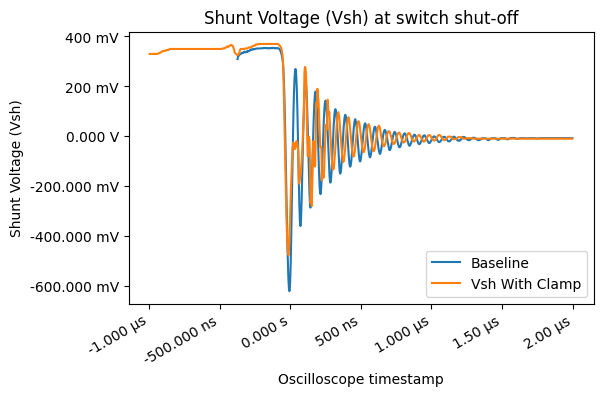

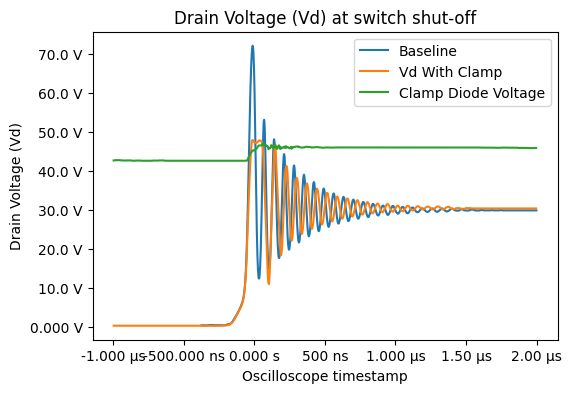

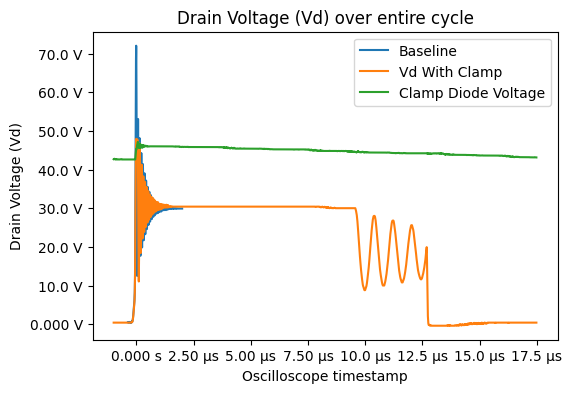

In [5]:
# Vd
bounds = (-1e-6, 2e-6)
df_clamp_zoom = df_clamp
df_baseline_zoom = df_baseline_hf
df_clamp_zoom = df_clamp[(df_clamp["t"] > bounds[0]) & (df_clamp["t"] < bounds[1])]
df_baseline_zoom = df_baseline_hf[(df_baseline_hf["t"] > bounds[0]) & (df_baseline_hf["t"] < bounds[1])]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (6, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) at switch shut-off", ax = ax1)
ax1.plot(df_baseline_zoom["t"], df_baseline_zoom["Vsh_baseline_hf"], label = "Baseline")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vsh"], label = "Vsh With Clamp")
ax1.legend(loc = "lower right")

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (6, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) at switch shut-off", ax = ax1)
ax1.plot(df_baseline_zoom["t"], df_baseline_zoom["Vd_baseline_hf"], label = "Baseline")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vd"], label = "Vd With Clamp")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vdiode"], label = "Clamp Diode Voltage")
ax1.legend(loc = "upper right")

df_clamp_zoom = df_clamp[(df_clamp["t"] > bounds[0]) & (df_clamp["t"] < 40e-6)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (6, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) over entire cycle", ax = ax1)
ax1.plot(df_baseline_zoom["t"], df_baseline_zoom["Vd_baseline_hf"], label = "Baseline")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vd"], label = "Vd With Clamp")
ax1.plot(df_clamp_zoom["t"], df_clamp_zoom["Vdiode"], label = "Clamp Diode Voltage")
ax1.legend(loc = "upper right")

The clamp voltage behaves exactly as expected. It cuts off the first one or two peaks of the drain voltage ringing when it exceeds 45V. Once the amplitude stays consistently below the clamp threshold, the ringing continues as normal. Note that this data was taken with the clamp in place but with the snubbers removed.

## PLECS Simulations
The snubbers and clamp are implemented on the lower right hand side of the schematic. They are made to be easily commented out in various combinations.

![PLECS Model Schematic with high-frequency and low-frequency snubber and clamp circuits](snubber_2_schematic.png)

In [6]:
bounds = (8.028e-3, 8.05e-3)

df_no_snubber = pd.read_csv("plecs_data_snubber_2/no_snubber.csv")
df_no_snubber.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_no_snubber = df_no_snubber.loc[(df_no_snubber["t"] > bounds[0]) & (df_no_snubber["t"] < bounds[1])]
df_no_snubber["t"] = df_no_snubber["t"] - bounds[0]

df_hf_snubber = pd.read_csv("plecs_data_snubber_2/hf_snubber.csv")
df_hf_snubber.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_hf_snubber = df_hf_snubber.loc[(df_hf_snubber["t"] > bounds[0]) & (df_hf_snubber["t"] < bounds[1])]
df_hf_snubber["t"] = df_hf_snubber["t"] - bounds[0]

df_lf_snubber = pd.read_csv("plecs_data_snubber_2/lf_snubber.csv")
df_lf_snubber.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_lf_snubber = df_lf_snubber.loc[(df_lf_snubber["t"] > bounds[0]) & (df_lf_snubber["t"] < bounds[1])]
df_lf_snubber["t"] = df_lf_snubber["t"] - bounds[0]

df_with_clamp = pd.read_csv("plecs_data_snubber_2/with_clamp.csv")
df_with_clamp.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_with_clamp = df_with_clamp.loc[(df_with_clamp["t"] > bounds[0]) & (df_with_clamp["t"] < bounds[1])]
df_with_clamp["t"] = df_with_clamp["t"] - bounds[0]

df_hf_snubber_and_clamp = pd.read_csv("plecs_data_snubber_2/hf_snubber_and_clamp.csv")
df_hf_snubber_and_clamp.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df_hf_snubber_and_clamp = df_hf_snubber_and_clamp.loc[(df_hf_snubber_and_clamp["t"] > bounds[0]) & (df_hf_snubber_and_clamp["t"] < bounds[1])]
df_hf_snubber_and_clamp["t"] = df_hf_snubber_and_clamp["t"] - bounds[0]

# print(df_no_snubber.head(1))
# print(df_with_clamp.head(1))

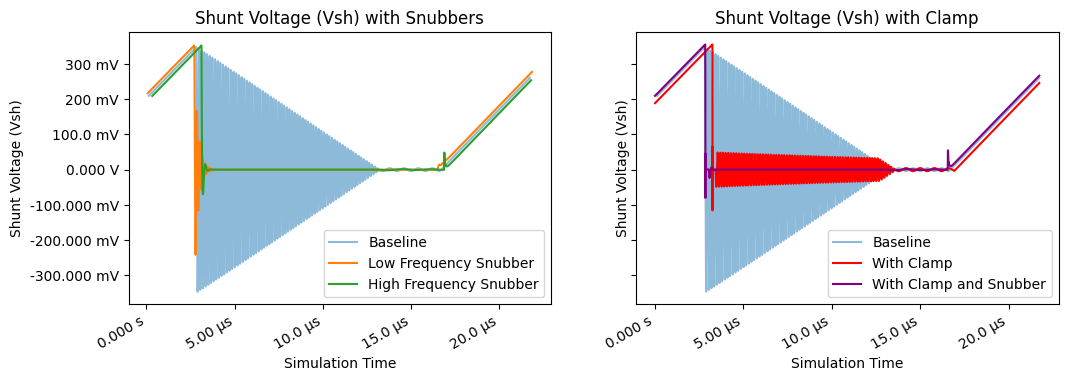

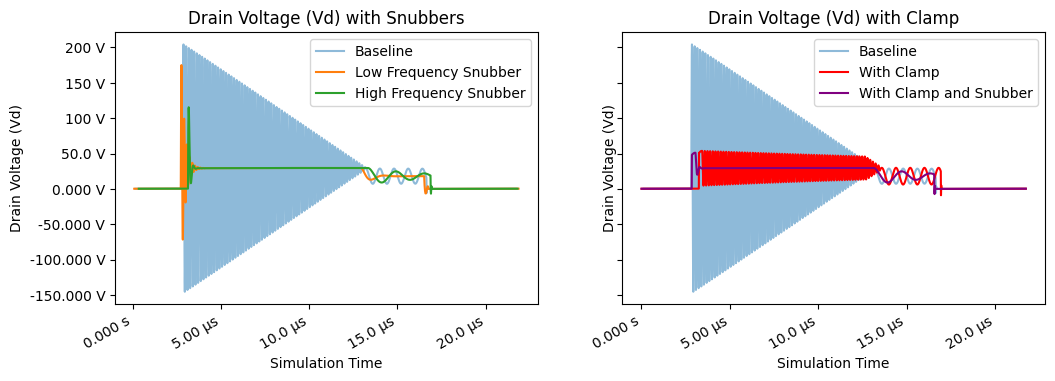

In [7]:
baseline_transparency = 0.5

# Vshunt
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Simulation Time", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) with Snubbers", ax = ax1)
ax1.plot(df_no_snubber["t"], df_no_snubber["V_Isense"], alpha = baseline_transparency, label = "Baseline")
ax1.plot(df_lf_snubber["t"], df_lf_snubber["V_Isense"], label = "Low Frequency Snubber")
ax1.plot(df_hf_snubber["t"], df_hf_snubber["V_Isense"], label = "High Frequency Snubber")
ax1.legend(loc = "lower right")

helper.axes_labels("Simulation Time", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh) with Clamp", ax = ax2)
ax2.plot(df_no_snubber["t"], df_no_snubber["V_Isense"], color = "#1f77b4", alpha = baseline_transparency, label = "Baseline")
ax2.plot(df_with_clamp["t"], df_with_clamp["V_Isense"], color = "red", label = "With Clamp")
ax2.plot(df_hf_snubber_and_clamp["t"], df_hf_snubber_and_clamp["V_Isense"], color = "purple", label = "With Clamp and Snubber")
ax2.legend(loc = "lower right")

# Vd
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Simulation Time", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) with Snubbers", ax = ax1)
ax1.plot(df_no_snubber["t"], df_no_snubber["Vdrain"], alpha = baseline_transparency, label = "Baseline")
ax1.plot(df_lf_snubber["t"], df_lf_snubber["Vdrain"], label = "Low Frequency Snubber")
ax1.plot(df_hf_snubber["t"], df_hf_snubber["Vdrain"], label = "High Frequency Snubber")
ax1.legend(loc = "upper right")

helper.axes_labels("Simulation Time", "s", "Drain Voltage (Vd)", "V", title = "Drain Voltage (Vd) with Clamp", ax = ax2)
ax2.plot(df_no_snubber["t"], df_no_snubber["Vdrain"], color = "#1f77b4", alpha = baseline_transparency, label = "Baseline")
ax2.plot(df_with_clamp["t"], df_with_clamp["Vdrain"], color = "red", label = "With Clamp")
ax2.plot(df_hf_snubber_and_clamp["t"], df_hf_snubber_and_clamp["Vdrain"], color = "purple", label = "With Clamp and Snubber")
ax2.legend(loc = "upper right")

The baseline simulation includes an LCR circuit consisting of the leakage inductance, parasitic capacitance, and shunt resistance in series. The simulated baseline ringing lasts much longer than the measured baseline ringing because the physical circuit has frequency-dependent AC resistance due to the skin effect and other factors which are not modeled. These high-frequency phenomena affect the switch shutoff ringing because it is much higher frequency (~20MHz) than the rest of the waveform.

Once the snubbers are added, the simulation results match closely with the measured waveform. In particular, the high frequency snubber yields near-critical damping on the switch shutoff ringing, and the low frequency snubber critically dampens or overdampens the diode shutoff response.

The snubber introduces an interesting spike in the shunt voltage

The clamp behaves as expected. In the absense of a snubber, it simply caps the drain voltage at around 50V when it would otherwise go higher; it does nothing to dampen the ringing. When both the clamp and the snubber are added, the switch shutoff response is nearly perfect: the drain voltage rises up to a safe maximum, stalls, then falls quickly to the desired output voltage.